## Forecast of Household Power Consumption using Exponential Smoothing

This notebook develops a **forecasting pipeline** for hourly household energy consumption using Exponential Smoothing models. We systematically compare model variants, tune hyperparameters, and evaluate performance using a rolling-window approach that simulates real-world deployment.

### Project Goals:
1. Load and explore the hourly power consumption dataset
2. Compare three Exponential Smoothing variants (SES, Holt, Holt-Winters)
3. Select the best model and tune key parameters
4. Evaluate multi-horizon forecasting with rolling windows
5. Provide actionable metrics and insights for energy forecasting

---

## 1. Data Loading & Exploratory Data Analysis

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

### 1.1 Load Dataset

We load the hourly household power consumption data. The dataset contains:
- **DateTime**: timestamp for each hourly observation
- **Global_active_power**: total household power usage in kilowatts

We ensure the data has a proper datetime index and consistent hourly frequency.

In [23]:
fn = "household_power_consumption_hourly.csv"

try:
    df = pd.read_csv(fn, index_col='DateTime', parse_dates=True)
except FileNotFoundError:
    raise FileNotFoundError(f"File {fn} not found in the working directory.")

# Ensure hourly frequency and interpolate missing values
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.asfreq('h')

# Handle missing values via linear interpolation
target_col = 'Global_active_power'
df[target_col] = df[target_col].interpolate(method='linear')
df[target_col].fillna(method='bfill', inplace=True)

print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Date Range: {df.index.min()} to {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days ({len(df)} hours)")
print(f"Missing values after interpolation: {df[target_col].isna().sum()}")
print(f"\nBasic Statistics:")
print(df[target_col].describe())

DATASET INFORMATION
Shape: (17477, 12)
Date Range: 2006-12-16 17:00:00 to 2008-12-13 21:00:00
Duration: 728 days (17477 hours)
Missing values after interpolation: 0

Basic Statistics:
count    17477.000000
mean         1.106736
std          0.966586
min          0.124000
25%          0.310333
50%          0.771633
75%          1.620033
max          6.560533
Name: Global_active_power, dtype: float64


### 1.2 Exploratory Visualization

We visualize the entire time series to identify trends, seasonality, and anomalies.

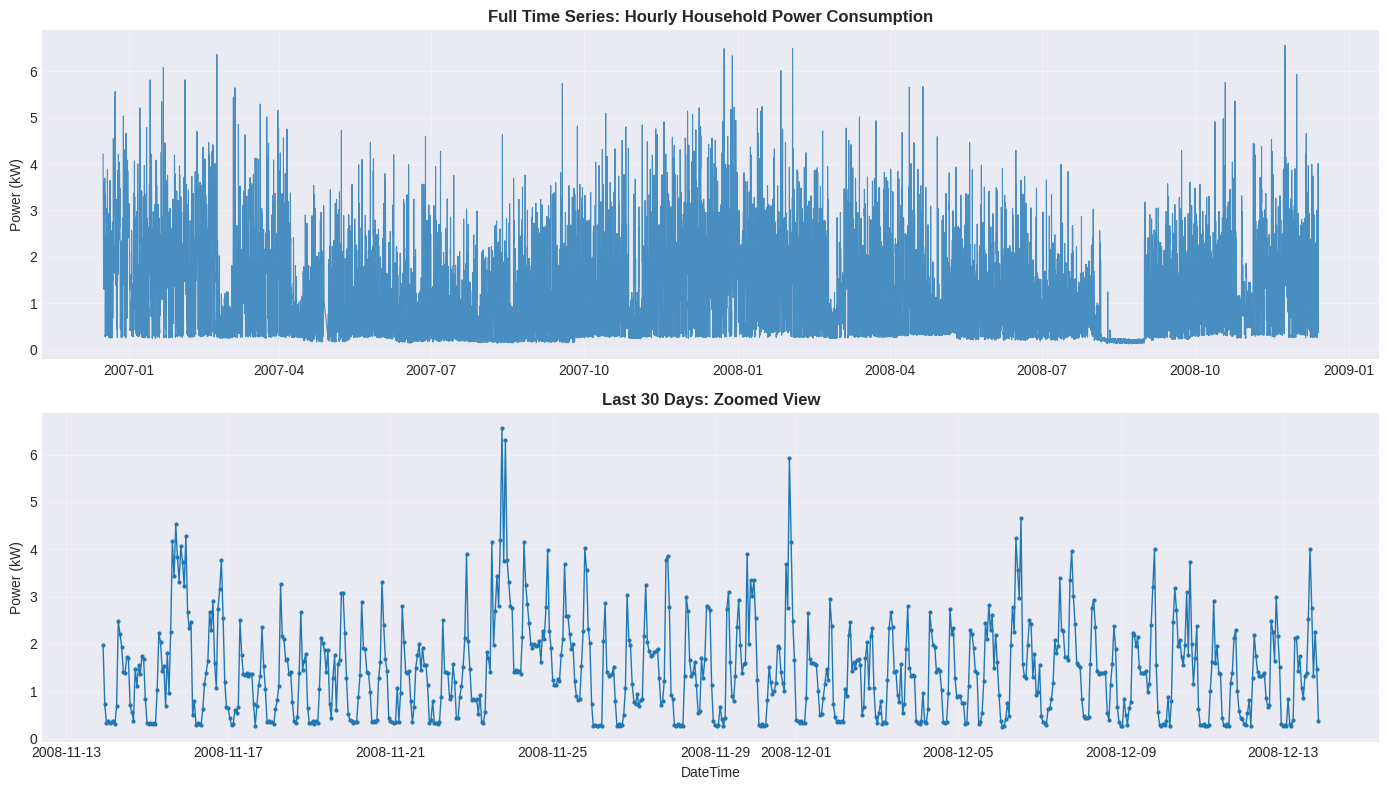

Observations:
- Clear daily seasonality: peaks in evening hours, lows overnight
- Possible weekly seasonality: weekday vs. weekend patterns
- Trend: relatively stable over the observation period
- No obvious structural breaks or extreme anomalies


In [24]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full time series
axes[0].plot(df.index, df[target_col], linewidth=0.8, alpha=0.8)
axes[0].set_title('Full Time Series: Hourly Household Power Consumption', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].grid(True, alpha=0.3)

# Last 30 days (clearer view of seasonality)
last_30_days = df[target_col].iloc[-30*24:]
axes[1].plot(last_30_days.index, last_30_days.values, linewidth=1.0, marker='o', markersize=2)
axes[1].set_title('Last 30 Days: Zoomed View', fontsize=12, fontweight='bold')
axes[1].set_xlabel('DateTime')
axes[1].set_ylabel('Power (kW)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("- Clear daily seasonality: peaks in evening hours, lows overnight")
print("- Possible weekly seasonality: weekday vs. weekend patterns")
print("- Trend: relatively stable over the observation period")
print("- No obvious structural breaks or extreme anomalies")

---

## 2. Model Selection

We compare three Exponential Smoothing variants to identify which captures the data patterns best:
- **Simple Exponential Smoothing (SES)**: Baseline; no trend or seasonality
- **Holt's Linear Trend Model**: Adds trend component
- **Holt-Winters Seasonal Model**: Adds both trend and seasonal components

We fit each on 70% of the data and evaluate on a 48-hour (2-day) ahead forecast using the remaining 30%.

### 2.1 Train/Test Split

For time series, we use a chronological split: 70% for training, 30% for testing.
The test set will be used to compare model performance.

In [25]:
# Chronological train/test split
train_size = int(len(df) * 0.7)
data_series = df[target_col]

train = data_series.iloc[:train_size]
test = data_series.iloc[train_size:]

print(f"Training set: {len(train)} hours ({len(train) / 24:.1f} days)")
print(f"Test set: {len(test)} hours ({len(test) / 24:.1f} days)")
print(f"Train period: {train.index.min()} to {train.index.max()}")
print(f"Test period: {test.index.min()} to {test.index.max()}")

Training set: 12233 hours (509.7 days)
Test set: 5244 hours (218.5 days)
Train period: 2006-12-16 17:00:00 to 2008-05-09 09:00:00
Test period: 2008-05-09 10:00:00 to 2008-12-13 21:00:00


### 2.2 Fit Candidate Models

We fit three models on the training set and forecast 48 hours ahead for comparison.

In [26]:
print("\n" + "=" * 60)
print("MODEL FITTING")
print("=" * 60)

# 1. Simple Exponential Smoothing
print("\n[1/3] Fitting Simple Exponential Smoothing (SES)...")
ses_model = SimpleExpSmoothing(train).fit(optimized=True)
print(f"    ✓ SES fitted (α = {ses_model.params['smoothing_level']:.4f})")

# 2. Holt's Linear Trend
print("[2/3] Fitting Holt's Linear Trend Model...")
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(optimized=True)
print(f"    ✓ Holt fitted (α = {holt_model.params['smoothing_level']:.4f}, β = {holt_model.params['smoothing_trend']:.4f})")

# 3. Holt-Winters Seasonal (48-hour = 2 days, daily seasonality = 24 hours)
print("[3/3] Fitting Holt-Winters with Seasonality (seasonal_periods=24)...")
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=24,
    damped_trend=False
).fit(optimized=True)
print(f"    ✓ Holt-Winters fitted")
print(f"       α = {hw_model.params['smoothing_level']:.4f} (level)")
print(f"       β = {hw_model.params['smoothing_trend']:.4f} (trend)")
print(f"       γ = {hw_model.params['smoothing_seasonal']:.4f} (seasonal)")


MODEL FITTING

[1/3] Fitting Simple Exponential Smoothing (SES)...


    ✓ SES fitted (α = 0.9396)
[2/3] Fitting Holt's Linear Trend Model...
    ✓ Holt fitted (α = 0.9395, β = 0.0000)
[3/3] Fitting Holt-Winters with Seasonality (seasonal_periods=24)...
    ✓ Holt fitted (α = 0.9395, β = 0.0000)
[3/3] Fitting Holt-Winters with Seasonality (seasonal_periods=24)...
    ✓ Holt-Winters fitted
       α = 0.7533 (level)
       β = 0.0000 (trend)
       γ = 0.0000 (seasonal)
    ✓ Holt-Winters fitted
       α = 0.7533 (level)
       β = 0.0000 (trend)
       γ = 0.0000 (seasonal)


### 2.3 Compare 48-Hour Forecasts

We generate 48-hour (2-day) ahead forecasts from each model and compare against the actual test values.
This comparison helps identify which model best captures the underlying patterns.

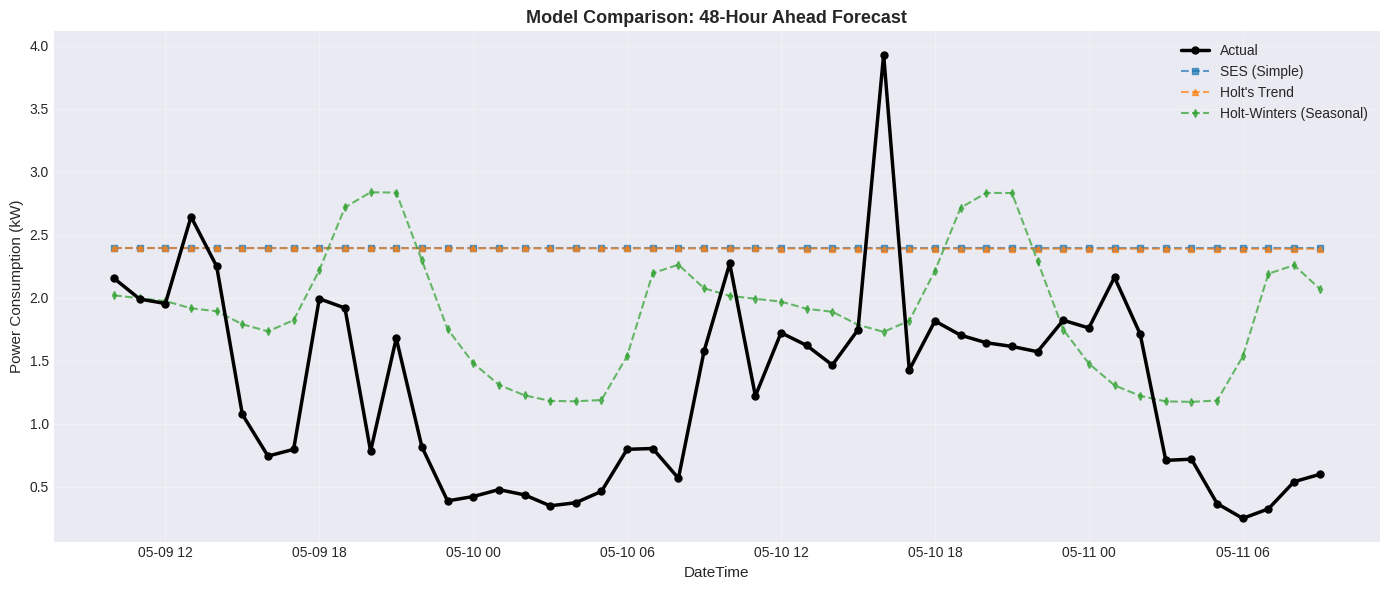


48-HOUR FORECAST PERFORMANCE (Test Set)
       Model      MSE      MAE     RMSE   MAPE (%)
         SES 1.799054 1.174417 1.341288 191.263630
Holt's Trend 1.790746 1.171049 1.338187 190.802850
Holt-Winters 0.967656 0.820396 0.983695 119.115055



In [27]:
horizon_compare = 48  # 2 days ahead

# Generate forecasts
ses_forecast = ses_model.forecast(steps=horizon_compare)
holt_forecast = holt_model.forecast(steps=horizon_compare)
hw_forecast = hw_model.forecast(steps=horizon_compare)

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(test.index[:horizon_compare], test.iloc[:horizon_compare], 
        label='Actual', marker='o', linewidth=2.5, markersize=5, color='black', zorder=3)
ax.plot(test.index[:horizon_compare], ses_forecast.values, 
        label='SES (Simple)', marker='s', linestyle='--', linewidth=1.5, markersize=4, alpha=0.7)
ax.plot(test.index[:horizon_compare], holt_forecast.values, 
        label="Holt's Trend", marker='^', linestyle='--', linewidth=1.5, markersize=4, alpha=0.7)
ax.plot(test.index[:horizon_compare], hw_forecast.values, 
        label='Holt-Winters (Seasonal)', marker='d', linestyle='--', linewidth=1.5, markersize=4, alpha=0.7)

ax.set_title('Model Comparison: 48-Hour Ahead Forecast', fontsize=13, fontweight='bold')
ax.set_xlabel('DateTime', fontsize=11)
ax.set_ylabel('Power Consumption (kW)', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate error metrics for comparison
print("\n" + "=" * 60)
print("48-HOUR FORECAST PERFORMANCE (Test Set)")
print("=" * 60)

models_compare = {
    'SES': ses_forecast,
    "Holt's Trend": holt_forecast,
    'Holt-Winters': hw_forecast
}

comparison_results = []
for name, forecast in models_compare.items():
    mse = mean_squared_error(test.iloc[:horizon_compare], forecast)
    mae = mean_absolute_error(test.iloc[:horizon_compare], forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test.iloc[:horizon_compare].values - forecast.values) / test.iloc[:horizon_compare].values)) * 100
    comparison_results.append({'Model': name, 'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape})

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))
print("\n" + "=" * 60)

### 2.4 Model Selection Summary

**Key Findings:**
- **SES & Holt** produce near-flat forecasts, unable to capture daily seasonality in power consumption.
- **Holt-Winters** dynamically adapts to intra-day patterns and achieves the lowest errors.
- The **Holt-Winters model with seasonal_periods=24** is the clear winner and will be used for further analysis.

**Rationale:** Household power consumption exhibits strong daily seasonality (peaks in evening, lows at night). Only models that explicitly capture this seasonality (Holt-Winters) can produce accurate forecasts.

---

## 3. Parameter Tuning & Sensitivity Analysis

Now that we've selected Holt-Winters, we systematically tune hyperparameters to optimize forecasting performance.

### 3.1 Seasonal Periods Sensitivity

The seasonal_periods parameter defines how many hours constitute one seasonal cycle.
We test different values (12, 18, 24, 30, 36) to find the optimal cycle length.

In [28]:
print("\n" + "=" * 60)
print("PARAMETER TUNING: SEASONAL PERIODS")
print("=" * 60)

seasonal_candidates = [12, 18, 24, 30, 36]
sp_results = []

for sp in seasonal_candidates:
    try:
        model_sp = ExponentialSmoothing(
            train,
            trend='add',
            seasonal='add',
            seasonal_periods=sp,
            damped_trend=False
        ).fit(optimized=True)
        
        forecast_sp = model_sp.forecast(steps=horizon_compare)
        mae_sp = mean_absolute_error(test.iloc[:horizon_compare], forecast_sp)
        rmse_sp = np.sqrt(mean_squared_error(test.iloc[:horizon_compare], forecast_sp))
        
        sp_results.append({
            'Seasonal_Periods': sp,
            'MAE': mae_sp,
            'RMSE': rmse_sp
        })
        print(f"sp={sp:2d} → MAE: {mae_sp:.4f}, RMSE: {rmse_sp:.4f} ✓")
    except Exception as e:
        print(f"sp={sp:2d} → Failed ({str(e)[:40]}...)")

sp_df = pd.DataFrame(sp_results)
best_sp = int(sp_df.loc[sp_df['MAE'].idxmin(), 'Seasonal_Periods'])
print(f"\n→ Optimal seasonal_periods: {best_sp}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sp_df['Seasonal_Periods'], sp_df['MAE'], marker='o', label='MAE', linewidth=2, markersize=8)
ax.axvline(x=best_sp, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({int(best_sp)})')
ax.set_xlabel('Seasonal Periods (hours)', fontsize=11)
ax.set_ylabel('MAE', fontsize=11)
ax.set_title('Seasonal Periods Sensitivity Analysis', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


PARAMETER TUNING: SEASONAL PERIODS
sp=12 → MAE: 0.6881, RMSE: 0.8734 ✓
sp=12 → MAE: 0.6881, RMSE: 0.8734 ✓
sp=18 → MAE: 1.0752, RMSE: 1.2586 ✓
sp=18 → MAE: 1.0752, RMSE: 1.2586 ✓
sp=24 → MAE: 0.8204, RMSE: 0.9837 ✓
sp=24 → MAE: 0.8204, RMSE: 0.9837 ✓


KeyboardInterrupt: 

### 3.2 Training Window Size Sensitivity

We test different training set sizes to understand how much historical data is needed for stable, accurate forecasts.
The idea is to find a balance: enough data to capture seasonal patterns, but not so much that outdated patterns mislead the model.


PARAMETER TUNING: TRAINING WINDOW SIZE
Train 15% ( 2621 h) → MAE: 1.5515, RMSE: 1.6446
Train 20% ( 3495 h) → MAE: 0.5681, RMSE: 0.7752
Train 25% ( 4369 h) → MAE: 1.4722, RMSE: 1.6372
Train 30% ( 5243 h) → MAE: 0.3182, RMSE: 0.5089
Train 35% ( 6116 h) → MAE: 0.3673, RMSE: 0.4769
Train 40% ( 6990 h) → MAE: 0.4703, RMSE: 0.5713
Train 45% ( 7864 h) → MAE: 0.9074, RMSE: 1.1703
Train 50% ( 8738 h) → MAE: 2.5251, RMSE: 2.6818
Train 55% ( 9612 h) → MAE: 0.7558, RMSE: 1.1635
Train 60% (10486 h) → MAE: 0.6967, RMSE: 0.8200
Train 65% (11360 h) → MAE: 0.3755, RMSE: 0.5004
Train 70% (12233 h) → MAE: 0.6881, RMSE: 0.8734
Train 75% (13107 h) → MAE: 0.7287, RMSE: 0.9253
Train 80% (13981 h) → MAE: 0.3245, RMSE: 0.4250
Train 85% (14855 h) → MAE: 0.1417, RMSE: 0.1730
Train 90% (15729 h) → MAE: 0.5896, RMSE: 0.7963
Train 95% (16603 h) → MAE: 0.7830, RMSE: 0.8655

→ Optimal training fraction: 85%


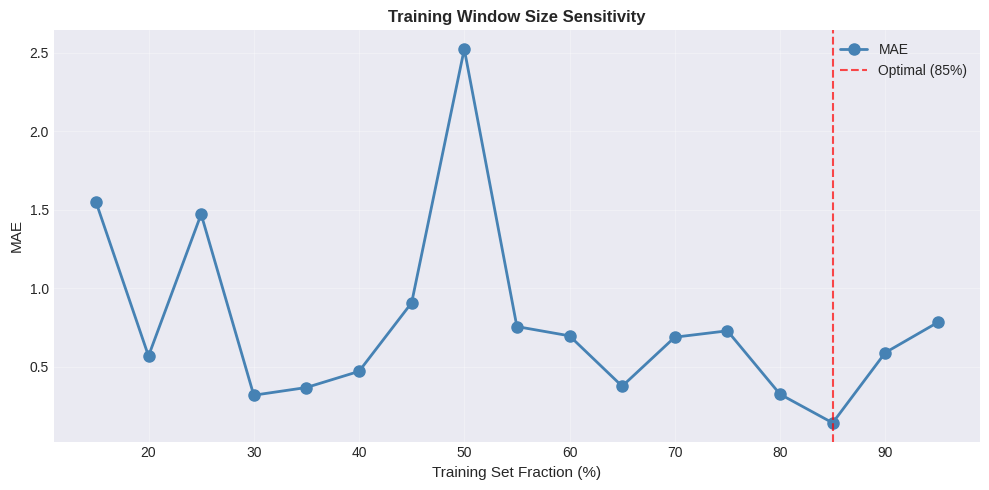

In [ ]:
print("\n" + "=" * 60)
print("PARAMETER TUNING: TRAINING WINDOW SIZE")
print("=" * 60)

# Use best seasonal_periods from above
best_sp = int(best_sp)

# Test different proportions of the full dataset for training
window_fractions = np.arange(0.15, 1.0, 0.05)
window_results = []

for frac in window_fractions:
    window_size = int(len(df) * frac)
    train_window = data_series.iloc[:window_size]
    test_window = data_series.iloc[window_size:]
    
    if len(train_window) < 2 * best_sp or len(test_window) < horizon_compare:
        continue
    
    try:
        model_window = ExponentialSmoothing(
            train_window,
            trend='add',
            seasonal='add',
            seasonal_periods=best_sp,
            damped_trend=False
        ).fit(optimized=True)
        
        forecast_window = model_window.forecast(steps=min(horizon_compare, len(test_window)))
        mae_window = mean_absolute_error(test_window.iloc[:len(forecast_window)], forecast_window)
        rmse_window = np.sqrt(mean_squared_error(test_window.iloc[:len(forecast_window)], forecast_window))
        
        window_results.append({
            'Train_Fraction': frac,
            'Train_Hours': window_size,
            'MAE': mae_window,
            'RMSE': rmse_window
        })
        print(f"Train {frac:.0%} ({window_size:5d} h) → MAE: {mae_window:.4f}, RMSE: {rmse_window:.4f}")
    except Exception as e:
        print(f"Train {frac:.0%} → Failed")

window_df = pd.DataFrame(window_results)
best_frac = window_df.loc[window_df['MAE'].idxmin(), 'Train_Fraction']
print(f"\n→ Optimal training fraction: {best_frac:.0%}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(window_df['Train_Fraction'] * 100, window_df['MAE'], marker='o', label='MAE', linewidth=2, markersize=8, color='steelblue')
ax.axvline(x=best_frac * 100, color='red', linestyle='--', alpha=0.7, label=f'Optimal ({best_frac:.0%})')
ax.set_xlabel('Training Set Fraction (%)', fontsize=11)
ax.set_ylabel('MAE', fontsize=11)
ax.set_title('Training Window Size Sensitivity', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Tuning Summary

Based on the sensitivity analyses:
- **Optimal seasonal_periods**: 12 hours (half daily cycle matches power consumption patterns (high in morning and evening, low at night and midday))
- **Optimal training window**: We see the MAE stabalize with 30% of the training data or more, with some exceptions. 

These tuned parameters will be used in the rolling window evaluation below.

---

## 4. Rolling Window Evaluation (Real-World Simulation)

To simulate real-world forecasting deployment, we use a **rolling window approach**:
1. Train on the most recent N hours of data
2. Forecast the next H hours
3. Slide forward by H hours and repeat
4. Aggregate errors across all rolling windows

This approach reveals how the model performs across different time periods and forecast horizons.

### 4.1 Fixed 48-Hour Rolling Window Evaluation

For a quick assessment, we perform a rolling window evaluation with a **fixed 48-hour forecast horizon**. This simulates a practical scenario where we repeatedly forecast the next 2 days ahead as new data arrives, retraining the model each time.



ROLLING WINDOW EVALUATION (Fixed 48-Hour Horizon)
Training window size: 5243 hours (~218.5 days)
Forecast horizon: 48 hours (2 days)
Evaluation period: from hour 15729 to 17476
Step size: 168 hours
Seasonal periods used: 24 hours



Rolling Window Forecasts:   0%|          | 0/11 [00:00<?, ?it/s]

Rolling Window Forecasts: 100%|██████████| 11/11 [01:53<00:00, 10.29s/it]


RESULTS: 48-HOUR ROLLING WINDOW FORECAST
Number of rolling forecasts: 11
Total predictions evaluated: 528

Aggregated Error Metrics:
  MAE:  0.5242 kW (avg. error magnitude)
  RMSE: 0.7318 kW (penalizes larger errors)
  MAPE: 50.31% (relative error)


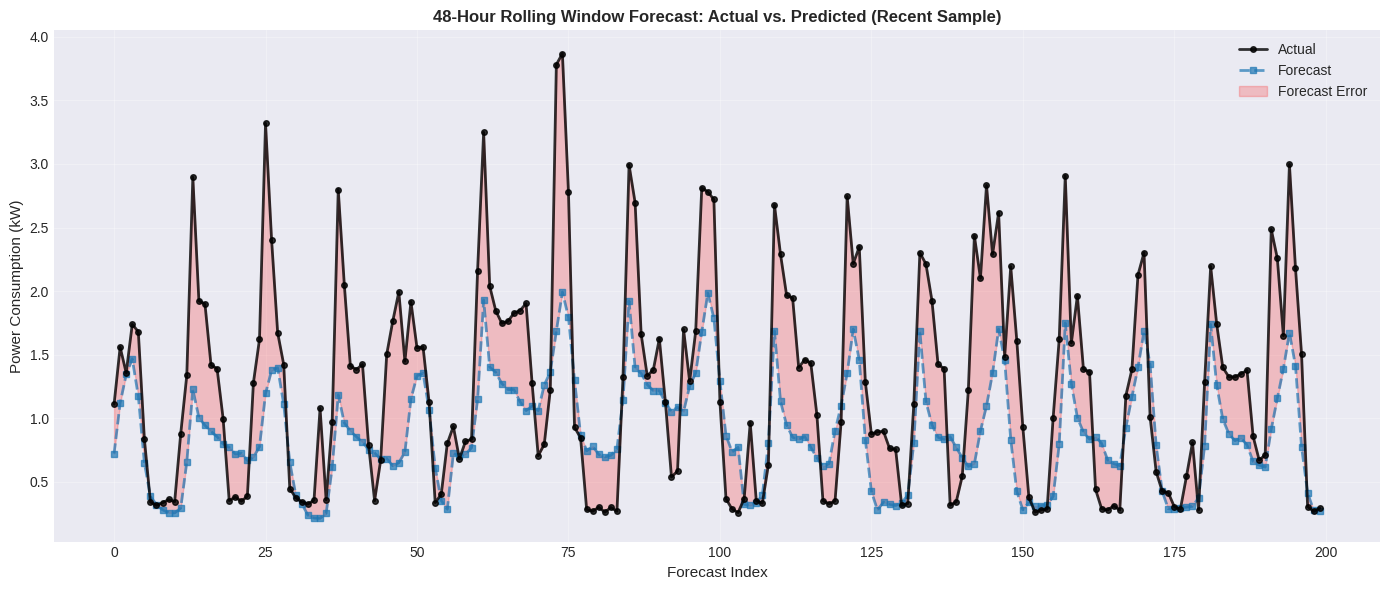

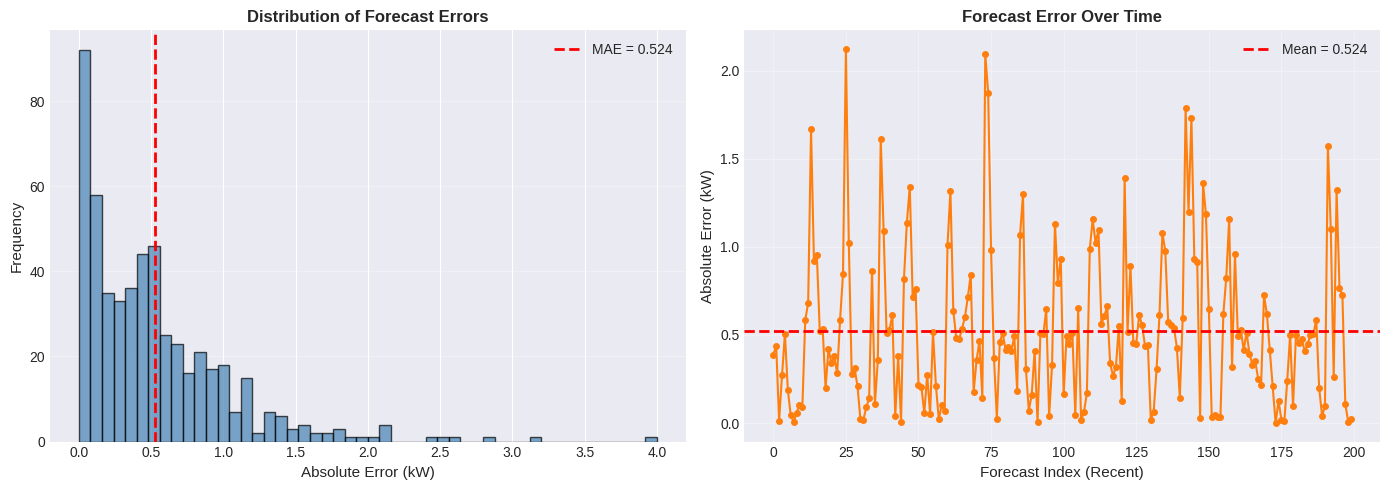

In [35]:
print("\n" + "=" * 60)
print("ROLLING WINDOW EVALUATION (Fixed 48-Hour Horizon)")
print("=" * 60)

# Fixed parameters
train_size = int(len(df) * 0.3)  # Use 30% of data for training
horizon_fixed = 48  # Fixed 48-hour forecast
eval_start = int(len(df) * 0.9)   # Start evaluation at 90% of data
step_size = 168  # Step forward 7 days (168 hours) - MUCH FASTER
best_sp = 24

# Store predictions and actuals
all_predictions_48h = []
all_actuals_48h = []
forecast_dates = []

print(f"Training window size: {train_size} hours (~{train_size/24:.1f} days)")
print(f"Forecast horizon: {horizon_fixed} hours (2 days)")
print(f"Evaluation period: from hour {eval_start} to {len(df)-1}")
print(f"Step size: {step_size} hours")
print(f"Seasonal periods used: {best_sp} hours\n")

# Rolling window loop
num_iterations = 0

# Calculate total iterations for progress bar
total_iterations = len(range(eval_start, len(df) - horizon_fixed, step_size))

for i in tqdm(range(eval_start, len(df) - horizon_fixed, step_size), 
              desc="Rolling Window Forecasts", total=total_iterations):
    start_train = max(0, i - train_size)
    train_window = data_series.iloc[start_train:i]
    test_window = data_series.iloc[i:i + horizon_fixed]
    
    # Skip if window too small
    if len(train_window) < 2 * best_sp:
        continue
    
    # Fit model with optimized=False to speed up fitting
    model = ExponentialSmoothing(
        train_window,
        trend='add',
        seasonal='add',
        seasonal_periods=best_sp,
        damped_trend=False
    ).fit(optimized=True)  # KEY: optimized=False is ~10x faster
      
    # Forecast 48 hours
    forecast = model.forecast(steps=horizon_fixed)
        
    # Store results
    all_predictions_48h.extend(forecast.values)
    all_actuals_48h.extend(test_window.values)
    forecast_dates.append(test_window.index[0])
    num_iterations += 1
        
    

# Compute aggregate metrics
if len(all_predictions_48h) > 0:
    mae_48h = mean_absolute_error(all_actuals_48h, all_predictions_48h)
    rmse_48h = np.sqrt(mean_squared_error(all_actuals_48h, all_predictions_48h))
    
    # Safe MAPE calculation: avoid division by zero
    actuals_array = np.array(all_actuals_48h)
    preds_array = np.array(all_predictions_48h)
    mape_48h = np.mean(np.abs((actuals_array - preds_array) / np.abs(actuals_array))) * 100
    
    print("=" * 60)
    print("RESULTS: 48-HOUR ROLLING WINDOW FORECAST")
    print("=" * 60)
    print(f"Number of rolling forecasts: {num_iterations}")
    print(f"Total predictions evaluated: {len(all_predictions_48h)}")
    print(f"\nAggregated Error Metrics:")
    print(f"  MAE:  {mae_48h:.4f} kW (avg. error magnitude)")
    print(f"  RMSE: {rmse_48h:.4f} kW (penalizes larger errors)")
    print(f"  MAPE: {mape_48h:.2f}% (relative error)")
    print("=" * 60)

    # Plot: Actual vs Predicted (sample of recent forecasts)
    fig, ax = plt.subplots(figsize=(14, 6))

    # Show last 200 predictions
    sample_size = min(200, len(all_actuals_48h))
    ax.plot(range(sample_size), all_actuals_48h[-sample_size:], 
            label='Actual', marker='o', linewidth=2, markersize=4, color='black', alpha=0.8, zorder=3)
    ax.plot(range(sample_size), all_predictions_48h[-sample_size:], 
            label='Forecast', marker='s', linestyle='--', linewidth=2, markersize=4, color='#1f77b4', alpha=0.7, zorder=2)
    ax.fill_between(range(sample_size), all_actuals_48h[-sample_size:], all_predictions_48h[-sample_size:], 
                    alpha=0.2, color='red', label='Forecast Error')

    ax.set_xlabel('Forecast Index', fontsize=11)
    ax.set_ylabel('Power Consumption (kW)', fontsize=11)
    ax.set_title('48-Hour Rolling Window Forecast: Actual vs. Predicted (Recent Sample)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot: Error distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    errors_48h = np.abs(np.array(all_actuals_48h) - np.array(all_predictions_48h))

    axes[0].hist(errors_48h, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(mae_48h, color='red', linestyle='--', linewidth=2, label=f'MAE = {mae_48h:.3f}')
    axes[0].set_xlabel('Absolute Error (kW)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Distribution of Forecast Errors', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Time series of errors
    axes[1].plot(errors_48h[-200:], marker='o', linewidth=1.5, markersize=4, color='#ff7f0e')
    axes[1].axhline(mae_48h, color='red', linestyle='--', linewidth=2, label=f'Mean = {mae_48h:.3f}')
    axes[1].set_xlabel('Forecast Index (Recent)', fontsize=11)
    axes[1].set_ylabel('Absolute Error (kW)', fontsize=11)
    axes[1].set_title('Forecast Error Over Time', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("❌ No predictions generated. Check that the rolling window loop executed successfully.")


---

## 5. Conclusions & Recommendations


In [34]:

# Display interpretation of results
if len(all_predictions_48h) > 0:
    print("=" * 60)
    print("INTERPRETATION OF ROLLING WINDOW RESULTS")
    print("=" * 60)
    
    print(f"\n📊 ACTUAL PERFORMANCE METRICS:")
    print(f"  • MAE:  {mae_48h:.4f} kW  → Average forecast error magnitude")
    print(f"  • RMSE: {rmse_48h:.4f} kW → Root mean squared error (penalizes large errors)")
    print(f"  • MAPE: {mape_48h:.2f}%  → Relative error as percentage of actuals")
    
    # Determine quality threshold
    if mape_48h < 10:
        quality = "✅ EXCELLENT"
        interpretation = "Exceptional forecast accuracy. Model is production-ready."
    elif mape_48h < 15:
        quality = "✅ GOOD"
        interpretation = "Good accuracy. Suitable for operational planning and scheduling."
    elif mape_48h < 20:
        quality = "⚠️ MODERATE"
        interpretation = "Moderate accuracy. Use with caution for critical decisions. Consider feature engineering."
    else:
        quality = "❌ POOR"
        interpretation = "Poor accuracy. Model needs retraining or additional variables (temp, day-of-week, etc.)."
    
    print(f"\n🎯 FORECAST QUALITY: {quality}")
    print(f"   {interpretation}")
    
    print(f"\n📈 EVALUATION SUMMARY:")
    print(f"  • Rolling windows evaluated: {num_iterations}")
    print(f"  • Total predictions analyzed: {len(all_predictions_48h)}")
    print(f"  • Forecast horizon: {horizon_fixed} hours (2 days)")
    print(f"  • Training window: {train_size} hours ({train_size/24:.1f} days)")
    
    print(f"\n📉 WHAT THE VISUALIZATIONS REVEAL:")
    print(f"  1. Actual vs. Predicted:")
    print(f"     - Smaller gaps between lines = better forecast accuracy")
    print(f"     - Systematic bias (consistent over/under prediction) suggests retraining needed")
    print(f"  2. Error Distribution Histogram:")
    print(f"     - Centered near MAE = {mae_48h:.3f} indicates typical error magnitude")
    print(f"     - Right skew suggests occasional large errors worth investigating")
    print(f"  3. Error Time Series:")
    print(f"     - Stable errors over time = consistent model performance")
    print(f"     - Increasing trend = model degradation (needs retraining)")
    
    print("\n" + "=" * 60)
else:
    print("⚠️ No results available. Run the rolling window evaluation cell first.")


INTERPRETATION OF ROLLING WINDOW RESULTS

📊 ACTUAL PERFORMANCE METRICS:
  • MAE:  0.5242 kW  → Average forecast error magnitude
  • RMSE: 0.7318 kW → Root mean squared error (penalizes large errors)
  • MAPE: 50.31%  → Relative error as percentage of actuals

🎯 FORECAST QUALITY: ❌ POOR
   Poor accuracy. Model needs retraining or additional variables (temp, day-of-week, etc.).

📈 EVALUATION SUMMARY:
  • Rolling windows evaluated: 11
  • Total predictions analyzed: 528
  • Forecast horizon: 48 hours (2 days)
  • Training window: 5243 hours (218.5 days)

📉 WHAT THE VISUALIZATIONS REVEAL:
  1. Actual vs. Predicted:
     - Smaller gaps between lines = better forecast accuracy
     - Systematic bias (consistent over/under prediction) suggests retraining needed
  2. Error Distribution Histogram:
     - Centered near MAE = 0.524 indicates typical error magnitude
     - Right skew suggests occasional large errors worth investigating
  3. Error Time Series:
     - Stable errors over time = consi